In [1]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import shutil

In [2]:
%bigquery schema --table "nyc-tlc:green.trips_2015"

In [3]:
%bq query
SELECT EXTRACT (DAYOFYEAR from pickup_datetime) AS daynumber FROM `nyc-tlc.green.trips_2015` LIMIT 10

daynumber
150
150
120
120
89
89
149
120
120
150


In [4]:
%bq query -n taxiquery
WITH trips AS (
  SELECT EXTRACT (DAYOFYEAR from pickup_datetime) AS daynumber FROM `nyc-tlc.green.trips_*`
  where _TABLE_SUFFIX = @YEAR
)
SELECT daynumber, COUNT(1) AS numtrips FROM trips
GROUP BY daynumber ORDER BY daynumber

In [5]:
query_parameters = [
  {
    'name': 'YEAR',
    'parameterType': {'type': 'STRING'},
    'parameterValue': {'value': 2015}
  }
]
trips = taxiquery.execute(query_params=query_parameters).result().to_dataframe()
trips[:5]

,daynumber,numtrips
0,1,62943
1,2,43410
2,3,53866
3,4,41602
4,5,41923


In [6]:
avg = np.mean(trips['numtrips'])
print 'Just using average={0} has RMSE of {1}'.format(avg, np.sqrt(np.mean((trips['numtrips'] - avg)**2)))

Just using average=54674.0994475 has RMSE of 10163.4654442


In [7]:
%bq query
SELECT * FROM `fh-bigquery.weather_gsod.stations`
WHERE state = 'NY' AND wban != '99999' AND name LIKE '%LA GUARDIA%'

usaf,wban,name,country,fips,state,call,lat,lon,elev,begin,end
725030,14732,NEW YORK/LA GUARDIA,US,US,NY,KLGA,40779.0,-73880.0,94,19350222,20120619


In [8]:
%bq query -n wxquery
SELECT EXTRACT (DAYOFYEAR FROM CAST(CONCAT(@YEAR,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber,
       MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(@YEAR,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
       MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
FROM `fh-bigquery.weather_gsod.gsod*`
WHERE stn='725030' AND _TABLE_SUFFIX = @YEAR
GROUP BY 1 ORDER BY daynumber DESC

In [9]:
query_parameters = [
  {
    'name': 'YEAR',
    'parameterType': {'type': 'STRING'},
    'parameterValue': {'value': 2015}
  }
]
weather = wxquery.execute(query_params=query_parameters).result().to_dataframe()
weather[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain
0,365,5,46.0,48.2,0.17
1,364,4,34.0,48.0,0.13
2,363,3,33.8,46.9,0.37
3,362,2,39.0,62.1,0.02
4,361,1,46.0,62.6,0.14


In [10]:
data = pd.merge(weather, trips, on='daynumber')
data[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
0,181,3,64.0,82.0,0.00,42978
1,180,2,62.1,78.1,0.26,41397
2,179,1,60.1,73.9,1.32,54632
3,178,7,62.1,80.1,0.00,74883
4,177,6,69.1,84.9,0.00,58371


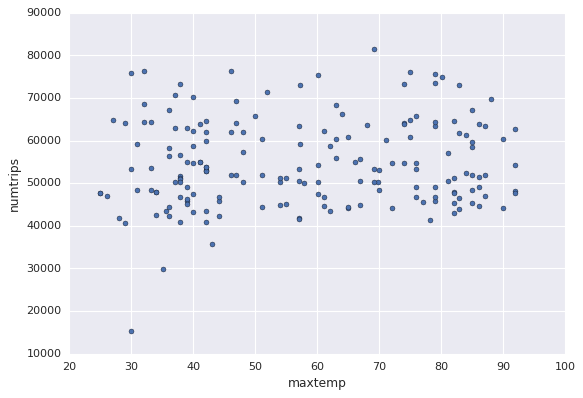

In [11]:
j = data.plot(kind='scatter', x='maxtemp', y='numtrips')

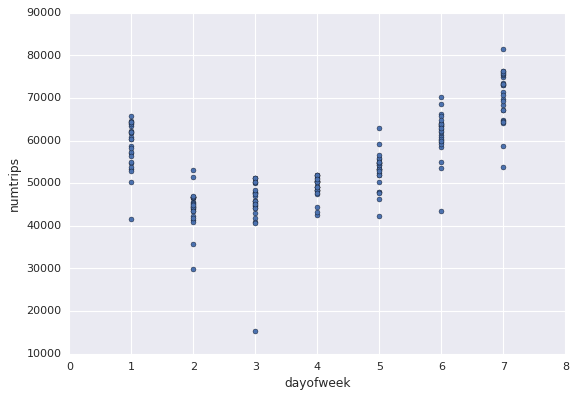

In [12]:
j = data.plot(kind='scatter', x='dayofweek', y='numtrips')

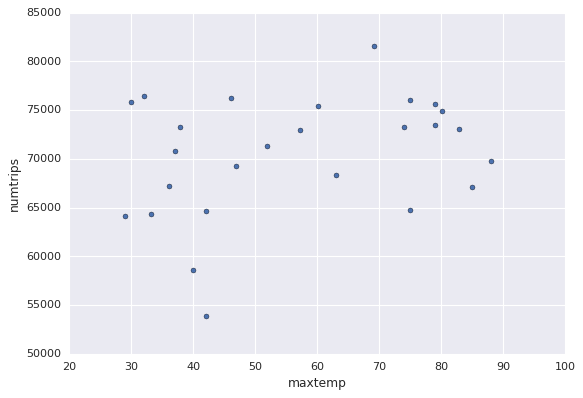

In [13]:
j = data[data['dayofweek'] == 7].plot(kind='scatter', x='maxtemp', y='numtrips')

In [14]:
query_parameters = [
  {
    'name': 'YEAR',
    'parameterType': {'type': 'STRING'},
    'parameterValue': {'value': 2014}
  }
]
weather = wxquery.execute(query_params=query_parameters).result().to_dataframe()
trips = taxiquery.execute(query_params=query_parameters).result().to_dataframe()
data2014 = pd.merge(weather, trips, on='daynumber')
data2014[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
0,365,4,27.0,35.1,0.0,67518
1,364,3,28.9,44.1,0.0,43173
2,363,2,37.9,52.0,0.1,37979
3,362,1,42.1,55.0,0.0,43055
4,361,7,39.9,55.0,0.0,46961


In [15]:
data2 = pd.concat([data, data2014])
data2.describe()

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,152.501832,4.000000,43.511355,61.806410,0.130568,47130.009158
std,101.099356,2.001834,18.598263,19.169493,0.360620,11613.865885
min,1.000000,1.000000,3.000000,21.000000,0.000000,13436.000000
25%,69.000000,2.000000,28.225000,44.100000,0.000000,39150.250000
50%,137.000000,4.000000,44.100000,64.000000,0.000000,46720.500000
75%,228.750000,6.000000,61.000000,79.000000,0.070000,53855.500000
max,365.000000,7.000000,75.900000,93.000000,4.880000,81574.000000


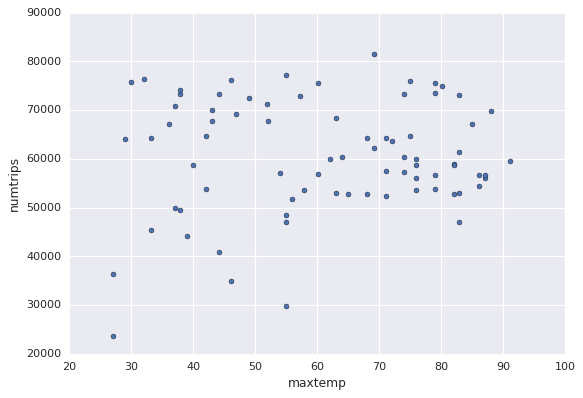

In [16]:
j = data2[data2['dayofweek'] == 7].plot(kind='scatter', x='maxtemp', y='numtrips')

In [17]:
import tensorflow as tf
shuffled = data2.sample(frac=1)
# It would be a good idea, if we had more data, to treat the days as categorical variables
# with the small amount of data, we have though, the model tends to overfit
#predictors = shuffled.iloc[:,2:5]
#for day in xrange(1,8):
#  matching = shuffled['dayofweek'] == day
#  predictors.loc[matching, 'day_' + str(day)] = 1
#  predictors.loc[~matching, 'day_' + str(day)] = 0
predictors = shuffled.iloc[:,1:5]
predictors[:5]

,dayofweek,mintemp,maxtemp,rain
358,3,3.9,36.0,0.24
68,6,51.1,62.1,0.23
64,2,45.0,61.0,0.00
110,5,37.0,60.1,0.02
161,4,72.0,89.1,0.00


In [18]:
shuffled[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
358,7,3,3.9,36.0,0.24,22719
68,297,6,51.1,62.1,0.23,55343
64,117,2,45.0,61.0,0.00,44694
110,71,5,37.0,60.1,0.02,54166
161,204,4,72.0,89.1,0.00,38895


In [19]:
targets = shuffled.iloc[:,5]
targets[:5]

358    22719
68     55343
64     44694
110    54166
161    38895
Name: numtrips, dtype: int64

In [20]:
trainsize = int(len(shuffled['numtrips']) * 0.8)
avg = np.mean(shuffled['numtrips'][:trainsize])
rmse = np.sqrt(np.mean((targets[trainsize:] - avg)**2))
print 'Just using average={0} has RMSE of {1}'.format(avg, rmse)

Just using average=47422.4678899 has RMSE of 10036.1751437


In [21]:
SCALE_NUM_TRIPS = 100000.0
trainsize = int(len(shuffled['numtrips']) * 0.8)
testsize = len(shuffled['numtrips']) - trainsize
npredictors = len(predictors.columns)
noutputs = 1
tf.logging.set_verbosity(tf.logging.WARN) # change to INFO to get output every 100 steps ...
shutil.rmtree('./trained_model_linear', ignore_errors=True) # so that we don't load weights from previous runs
estimator = tf.contrib.learn.LinearRegressor(model_dir='./trained_model_linear',
                                             optimizer=tf.train.AdamOptimizer(learning_rate=0.1),
                                             enable_centered_bias=False,
                                             feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(predictors.values))

print "starting to train ... this will take a while ... use verbosity=INFO to get more verbose output"
def input_fn(features, targets):
  return tf.constant(features.values), tf.constant(targets.values.reshape(len(targets), noutputs)/SCALE_NUM_TRIPS)
estimator.fit(input_fn=lambda: input_fn(predictors[:trainsize], targets[:trainsize]), steps=10000)

pred = np.multiply(list(estimator.predict(predictors[trainsize:].values)), SCALE_NUM_TRIPS )
rmse = np.sqrt(np.mean(np.power((targets[trainsize:].values - pred), 2)))
print 'LinearRegression has RMSE of {0}'.format(rmse)

starting to train ... this will take a while ... use verbosity=INFO to get more verbose output
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
LinearRegression has RMSE of 9620.80678152


/usr/local/lib/python2.7/dist-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


In [22]:
SCALE_NUM_TRIPS = 100000.0
trainsize = int(len(shuffled['numtrips']) * 0.8)
testsize = len(shuffled['numtrips']) - trainsize
npredictors = len(predictors.columns)
noutputs = 1
tf.logging.set_verbosity(tf.logging.WARN) # change to INFO to get output every 100 steps ...
shutil.rmtree('./trained_model', ignore_errors=True) # so that we don't load weights from previous runs
estimator = tf.contrib.learn.DNNRegressor(model_dir='./trained_model',
                                          hidden_units=[5, 2],
                                          optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
                                          enable_centered_bias=False,
                                          feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(predictors.values))

print "starting to train ... this will take a while ... use verbosity=INFO to get more verbose output"
def input_fn(features, targets):
  return tf.constant(features.values), tf.constant(targets.values.reshape(len(targets), noutputs)/SCALE_NUM_TRIPS)
estimator.fit(input_fn=lambda: input_fn(predictors[:trainsize], targets[:trainsize]), steps=10000)

pred = np.multiply(list(estimator.predict(predictors[trainsize:].values)), SCALE_NUM_TRIPS )
rmse = np.sqrt(np.mean((targets[trainsize:].values - pred)**2))
print 'Neural Network Regression has RMSE of {0}'.format(rmse)

starting to train ... this will take a while ... use verbosity=INFO to get more verbose output
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Neural Network Regression has RMSE of 8806.66426636


In [23]:
input = pd.DataFrame.from_dict(data = 
                               {'dayofweek' : [4, 5, 6],
                                'mintemp' : [30, 60, 50],
                                'maxtemp' : [40, 70, 60],
                                'rain' : [0, 0.8, 0]})
# read trained model from ./trained_model
estimator = tf.contrib.learn.LinearRegressor(model_dir='./trained_model_linear',
                                          enable_centered_bias=False,
                                          feature_columns=tf.contrib.learn.infer_real_valued_columns_from_input(input.values))

pred = np.multiply(list(estimator.predict(input.values)), SCALE_NUM_TRIPS )
print pred

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
[ 44152.875       46732.66796875  49691.23046875]
